# Небольшой шаблончик для работы с сетками

# Часть 0 - Улучшение .to function чтобы разные исходные данные обрабатывать

In [19]:
def move_to_device(batch, device):
  if isinstance(batch, (list, tuple)):
    return [move_to_device(x, device) for x in batch]
  elif isinstance(batch, dict):
    return {k: move_to_device(v, device) for k, v in batch.items()}
  return batch.to(device)

# Часть 1 - Чепоинты

In [20]:
import os
import torch

def save_checkpoint(model, optimizer, scheduler, epoch, best_score, path="checkpoint.pt"):
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_score": best_score
    }
    if scheduler is not None:
        checkpoint["scheduler_state"] = scheduler.state_dict()
    torch.save(checkpoint, path)

def load_checkpoint(model, optimizer, scheduler=None, path="checkpoint.pt", device="cpu"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    best_score = checkpoint["best_score"]
    start_epoch = checkpoint["epoch"] + 1
    if scheduler is not None and "scheduler_state" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state"])
    print(f"Loaded checkpoint from previous epochs: {checkpoint['epoch']}, best_score={best_score:.4f}")
    return start_epoch, best_score

# Часть 1.1 пара вспомогательных функций

In [21]:
# Пришлось добавить т.к. там есть warning в зависимости от версии торча

def get_grad_scaler(use_amp):
    if not use_amp:
        return None
    try:
        # Новый API (PyTorch ≥ 2.2)
        return torch.amp.GradScaler(device_type="cuda")
    except TypeError:
        # Старый API (PyTorch ≤ 2.1)
        return torch.cuda.amp.GradScaler()

def get_autocast(use_amp, device):
    if not use_amp:
        return nullcontext()
    try:
        return torch.amp.autocast(device_type=device)
    except TypeError:
        return torch.cuda.amp.autocast()

# Часть 2 - Обучение

In [22]:
from tqdm import tqdm
import torch.nn.functional as F
from contextlib import nullcontext

def train_epoch(model, optimizer, loader, loss_fn, device, grad_clip = None, metric_fn = None, scaler=None, use_amp=False, ema=None):
  model.train()
  total_loss, metric_sum, total = 0.0, 0, 0

  for data, target in tqdm(loader, desc="Training", leave=False):
    data, target = move_to_device(data, device), move_to_device(target, device)


    # Для лучшего performance
    with get_autocast(use_amp, device.type):
            predictions = model(data)
            loss = loss_fn(predictions, target)


    if scaler is not None:
      scaler.scale(loss).backward()
      # В случае если хочется использовать регуляризацию значений для града
      if grad_clip is not None:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
      scaler.step(optimizer)
      scaler.update()

    else:
      loss.backward()
      # В случае если хочется использовать регуляризацию значений для града
      if grad_clip is not None:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
      optimizer.step()

    optimizer.zero_grad()

    # В некоторых случаях может улучшить качество модели

    total_loss += loss.item() * target.size(0)

    if metric_fn is not None:
            metric_sum += metric_fn(predictions, target) * target.size(0)

    total += target.size(0)

  avg_loss = total_loss / total
  avg_metric = metric_sum / total if metric_fn is not None else None
  return avg_loss, avg_metric

In [23]:
def train(model, optimizer, n_epochs, train_loader, val_loader, device,
          loss_fn=F.cross_entropy, scheduler=None, grad_clip=None, checkpoint_path="best_model.pt",
          resume=False, metric="val_loss", save_last=True, metric_fn=None, use_amp=False, save_every=None,
            improvement_fn=None, early_stopping_patience=None, warmup_scheduler=None):

  scaler = get_grad_scaler(use_amp)

  if improvement_fn is None:
    if metric_fn is None or metric == "val_loss":
      improvement_fn = lambda current, best: current < best
      best_score = float("inf")
    else:
      improvement_fn = lambda current, best: current > best
      best_score = 0.0

  if resume and os.path.exists(checkpoint_path):
        start_epoch, best_score = load_checkpoint(model, optimizer, scheduler, checkpoint_path, device)
  else:
        start_epoch, best_score = 1, (float("inf") if metric == "val_loss" else 0.0)

  train_loss_log, train_metric_log, val_loss_log, val_metric_log = [], [], [], []

  patience_counter = 0

  for epoch in range(1, n_epochs+1):
    print(f"\nEpoch {epoch}/{n_epochs}")

    train_loss, train_metric = train_epoch(model, optimizer, train_loader, loss_fn, device, grad_clip, metric_fn, scaler, use_amp)
    val_loss, val_metric = evaluate(model, val_loader, loss_fn, device, metric_fn)

    train_loss_log.append(train_loss)
    train_metric_log.append(train_metric)
    val_loss_log.append(val_loss)
    val_metric_log.append(val_metric)

    print(f" train loss: {train_loss:.4f}, train acc: {train_metric:.4f}")
    print(f" val loss: {val_loss:.4f}, val acc: {val_metric:.4f}")

    if warmup_scheduler is not None:
      warmup_scheduler.step()

    if scheduler is not None:
      scheduler.step()

    current_score = val_loss if (metric_fn is None or metric == "val_loss") else val_metric

    if improvement_fn(current_score, best_score):
      patience_counter = 0
      best_score = current_score
      save_checkpoint(model, optimizer, scheduler, epoch, best_score, checkpoint_path)
      print(f"Saved new best model ({metric}={best_score:.4f})")

    else:
      patience_counter+=1
      if save_last:
        save_checkpoint(model, optimizer, scheduler, epoch, best_score, "last_model.pt")

    if save_every is not None and epoch % save_every == 0:
      save_checkpoint(model, optimizer, scheduler, epoch, best_score, f"checkpoint_epoch_{epoch}.pt")

    if early_stopping_patience is not None and patience_counter >= early_stopping_patience:
            print("Early stopping triggered!")
            break

  return train_loss_log, train_metric_log, val_loss_log, val_metric_log

In [24]:
def evaluate(model, loader, loss_fn, device, metric_fn=None):
  model.eval()
  total_loss, metric_sum, total = 0.0, 0, 0

  with torch.no_grad():
    for data, target in loader:
      data, target = move_to_device(data, device), move_to_device(target, device)
      predictions = model(data)
      loss = loss_fn(predictions, target)
      total_loss += loss.item()*target.size(0)

      if metric_fn is not None:
              metric_sum += metric_fn(predictions, target) * target.size(0)

      total += target.size(0)

  avg_loss = total_loss/total
  avg_metric = metric_sum / total if metric_fn is not None else None
  return avg_loss, avg_metric

In [25]:
# В качестве примеров

def accuracy(predictions, target):
    return (predictions.argmax(dim=1) == target).float().mean().item()

def binary_accuracy(predictions, target):
    preds = (torch.sigmoid(predictions) > 0.5).long()
    return (preds == target).float().mean().item()

def mse(predictions, target):
    return F.mse_loss(predictions, target).item()


# Часть 3 - рисовашки потерь и значения  метрики

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reses(train_loss, train_metric, val_loss, val_metric, metric_name="Metric"):

    epochs = np.arange(1, len(train_loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

    # Для loss
    ax1.plot(epochs, train_loss, label='Train Loss', color='#1f77b4', linewidth=2)
    ax1.plot(epochs, val_loss, label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    ax1.set_xticks(epochs)
    ax1.tick_params(axis='both', labelsize=10)

    # Для вашей метрики
    ax2.plot(epochs, train_metric, label=f'Train {metric_name}', color='#1f77b4', linewidth=2)
    ax2.plot(epochs, val_metric, label=f'Validation {metric_name}', color='#ff7f0e', linestyle='--', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel(metric_name)
    ax2.set_title(f'Training and Validation {metric_name}')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    ax2.set_xticks(epochs)
    ax2.tick_params(axis='both', labelsize=10)

    plt.tight_layout()
    plt.show()

# Часть 4 - Ну и небольшой примерчик как все вместе может выглядеть

In [27]:

from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3)
        self.fc = nn.Linear(26*26*32, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SimpleCNN().to(device)

transform = transforms.ToTensor()
train_data = datasets.MNIST(root=".", train=True, transform=transform, download=True)
val_data = datasets.MNIST(root=".", train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loss_log, train_metric_log, val_loss_log, val_metric_log = train(
  model=model,
  optimizer=optimizer,
  n_epochs=5,
  train_loader=train_loader,
  val_loader=val_loader,
  device=device,
  loss_fn=nn.CrossEntropyLoss(),
  metric_fn=accuracy,
  checkpoint_path="mnist_best.pt",
  resume=False,
  metric="val_metric",
  save_last=True, # Всегда сохраняет последнюю модельку
  save_every=2, # Сохраняет каждую n-ую эпоху (сейчас каждую вторую)
  use_amp=True # Вот посмотрим как оно работает
)

/tmp/ipython-input-923298972.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()



Epoch 1/5


 train loss: 0.1939, train acc: 0.9427
 val loss: 0.0812, val acc: 0.9750
Saved new best model (val_metric=0.9750)

Epoch 2/5


 train loss: 0.0694, train acc: 0.9795
 val loss: 0.0839, val acc: 0.9743

Epoch 3/5


 train loss: 0.0485, train acc: 0.9855
 val loss: 0.0646, val acc: 0.9789
Saved new best model (val_metric=0.9789)

Epoch 4/5


 train loss: 0.0366, train acc: 0.9890
 val loss: 0.0584, val acc: 0.9815
Saved new best model (val_metric=0.9815)

Epoch 5/5


 train loss: 0.0279, train acc: 0.9916
 val loss: 0.0595, val acc: 0.9814


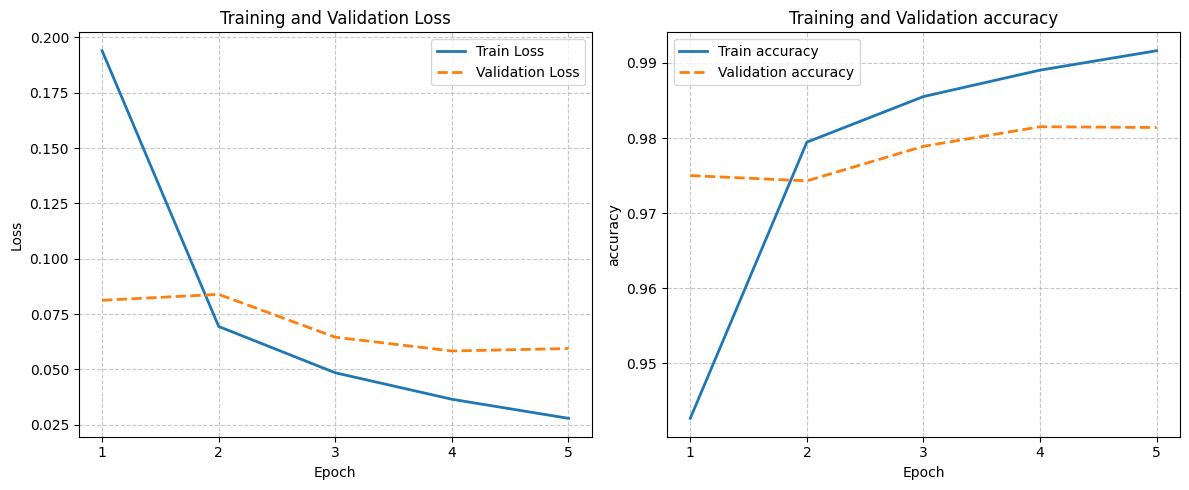

In [28]:
plot_reses(train_loss_log, train_metric_log, val_loss_log, val_metric_log, metric_name='accuracy')